## Petrophysical properties inversion from seismic data

In [2]:
import scipy.io as sio
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import numpy as np
from random import randint
from wiggle.wiggle import wiggle
from matplotlib.pyplot import figure
import math
import tensorflow as tf

In [3]:
# Checking the devices available for use in AWS
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6477282190872957891
]


In [4]:
# Loading the Vp, Vs and Density data

dataframe = sio.loadmat('../../../Data_generation_base_case/Train_DataSyn1_time_clip.mat')
Vp = dataframe['VpMat']
Vp = np.reshape(Vp, (Vp.shape[0]*Vp.shape[1], Vp.shape[2]))
Vs = dataframe['VsMat']
Vs = np.reshape(Vs, (Vs.shape[0]*Vs.shape[1], Vs.shape[2]))
RHOB = dataframe['RHOBMat']
RHOB = np.reshape(RHOB, (RHOB.shape[0]*RHOB.shape[1], RHOB.shape[2]))

depth = dataframe['depthVec']

# Loading facies, porosity, vclay and water saturation data 
dataframe_facies = sio.loadmat('../../../Data_generation_base_case/Train_FaciesMat.mat')
facies = dataframe_facies['zFaciesMat']
facies = np.reshape(facies, (facies.shape[0]*facies.shape[1], facies.shape[2]))

dataframe_porosity = sio.loadmat('../../../Data_generation_base_case/Train_PhiMat.mat')
porosity = dataframe_porosity['zPhiMat']
porosity = np.reshape(porosity, (porosity.shape[0]*porosity.shape[1], porosity.shape[2]))

dataframe_vclay = sio.loadmat('../../../Data_generation_base_case/Train_ClayMat.mat')
vclay = dataframe_vclay['zClayMat']
vclay = np.reshape(vclay, (vclay.shape[0]*vclay.shape[1], vclay.shape[2]))

dataframe_Sw = sio.loadmat('../../../Data_generation_base_case/Train_SwMat.mat')
Sw = dataframe_Sw['zSwMat']
Sw = np.reshape(Sw, (Sw.shape[0]*Sw.shape[1], Sw.shape[2]))


Text(0.5,0,'Ip')

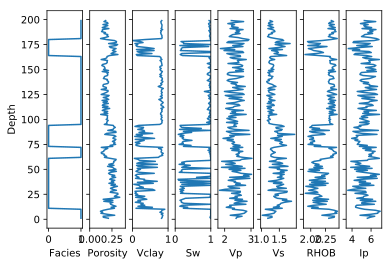

In [5]:
# Plot of loaded data

sample_number = 12
f, axarr = plt.subplots(1, 8, sharey = True)

axarr[0].plot(facies[sample_number, :], depth)
axarr[0].set_xlabel("Facies")
axarr[0].set_ylabel("Depth")

axarr[1].plot(porosity[sample_number, :], depth)
axarr[1].set_xlabel("Porosity")
axarr[1].set_xlim(0,0.4)

axarr[2].plot(vclay[sample_number, :], depth)
axarr[2].set_xlabel("Vclay")
axarr[2].set_xlim(0,1)

axarr[3].plot(Sw[sample_number, :], depth)
axarr[3].set_xlabel("Sw")
axarr[3].set_xlim(0,1)

axarr[4].plot(Vp[sample_number, :], depth)
axarr[4].set_xlabel("Vp")
# plt.xlim(0,1)

axarr[5].plot(Vs[sample_number, :], depth)
axarr[5].set_xlabel("Vs")
# plt.xlim(0,1)

axarr[6].plot(RHOB[sample_number, :], depth)
axarr[6].set_xlabel("RHOB")
# plt.xlim(0,1)

axarr[7].plot(Vp[sample_number, :]*RHOB[sample_number, :], depth)
axarr[7].set_xlabel("Ip")

In [6]:
# AVO and source parameters 
src_len=np.int(60)
freq=40
dt=7e-4
# ntheta=46
thetaStart=0
thetaEnd=30
thetaInc=5
theta=np.arange(thetaStart,thetaEnd+thetaInc,thetaInc)
ntheta=theta.size
# nt=201
# ncdp=1111
angle=np.reshape(theta,[1,ntheta])
# theta=np.arange(0,ntheta,1)
print('angle:', angle.shape)
print('angle:', angle)

angle: (1, 7)
angle: [[ 0  5 10 15 20 25 30]]


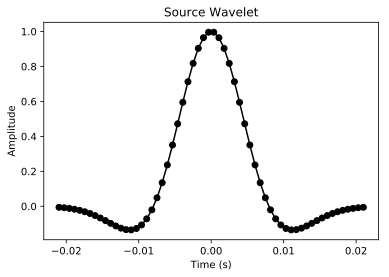

In [7]:
# Generate the seismic wavelet
def ricker(f,n,dt,t0):

    T = dt*(np.floor(n/2));
    t = np.linspace(-T,T,n)
    tau = t-t0;
    pi=np.pi
    s = (1-tau*tau*f**2*pi**2)*np.exp(-tau**2*pi**2*f**2);
    rw = s;

    return rw,t
src,tsrc=ricker(freq,src_len,dt,0)
plt.plot(tsrc,src, '-ok')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Source Wavelet")
plt.show()

In [8]:
# Full Zoeppritz using tensorflow

def gather(input1,tftheta,tfsrc):
    print('input1:',input1)
    vp = tf.expand_dims(input1[:,:,0],2)
    vs = tf.expand_dims(input1[:,:,1],2)
    rho = tf.expand_dims(input1[:,:,2],2)
    vp=tf.check_numerics(vp,"Nan at vp start")
    vs=tf.check_numerics(vs,"Nan at vp start")
    rho=tf.check_numerics(rho,"Nan at vp start")
    

    nref= tf.shape(input1)[1]#vp.get_shape()[1]#.as_list()[1]
    bs=tf.shape(input1)[0]
    ntheta=tf.shape(tftheta)[1]
    #nt=tf.shape(input1)[1]
    
    tfzero=tf.zeros([bs,1,ntheta], dtype=tf.float32)
    
    tfangle = tf.expand_dims(tf.convert_to_tensor(tftheta, 
                                                  dtype=tf.float32),0)
    tfangle=tf.tile(tfangle,[bs,nref-1,1])

  
    vp1=tf.tile(vp[:,0:nref-1],[1, 1, ntheta])
    vs1=tf.tile(vs[:,0:nref-1],[1, 1, ntheta])
    d1=tf.tile(rho[:,0:nref-1],[1, 1, ntheta])

    vp2=tf.tile(vp[:,1:nref],[1, 1, ntheta])
    vs2=tf.tile(vs[:,1:nref],[1, 1, ntheta])
    d2=tf.tile(rho[:,1:nref],[1, 1, ntheta])
    
    
    vpj1=tf.complex(vp1,tf.zeros_like(vp1))
    vsj1=tf.complex(vs1,tf.zeros_like(vs1))
    dj1=tf.complex(d1,tf.zeros_like(d1))

    vpj2=tf.complex(vp2,tf.zeros_like(vp2))
    vsj2=tf.complex(vs2,tf.zeros_like(vs2))
    dj2=tf.complex(d2,tf.zeros_like(d2))
    
    
    t=tf.scalar_mul(np.pi/180,tfangle)    
    p=tf.divide(tf.sin(t),vp1)
    ct=tf.cos(t)
    
    sint=tf.complex(tf.sin(t),tf.zeros_like(t))
    
    # FULL ZOEPPRITZ
    ct2=tf.real(tf.sqrt(np.subtract(1+0j,tf.multiply(tf.square(sint)
                , tf.divide(tf.square(vpj2),tf.square(vpj1))))))
    
    cj1=tf.real(tf.sqrt(np.subtract(1+0j,tf.multiply(tf.square(sint)
                , tf.divide(tf.square(vsj1),tf.square(vpj1))))))
    
    cj2=tf.real(tf.sqrt(np.subtract(1+0j,tf.multiply(tf.square(sint)
                , tf.divide(tf.square(vsj2),tf.square(vpj1))))))
    
    a=tf.subtract(
            tf.multiply(d2, tf.subtract(1.0, tf.scalar_mul(2.0,tf.multiply(tf.square(vs2), tf.square(p))))),
            tf.multiply(d1, tf.subtract(1.0, tf.scalar_mul(2.0,tf.multiply(tf.square(vs1), tf.square(p)))))
            )
    
    b=tf.add(
            tf.multiply(d2, tf.subtract(1.0, tf.scalar_mul(2.0,tf.multiply(tf.square(vs2), tf.square(p))))),
            tf.multiply(d1,tf.scalar_mul(2.0,tf.multiply(tf.square(vs1), tf.square(p))))
            )
    c=tf.add(
            tf.multiply(d1, tf.subtract(1.0, tf.scalar_mul(2.0,tf.multiply(tf.square(vs1), tf.square(p))))),
            tf.multiply(d2,tf.scalar_mul(2.0,tf.multiply(tf.square(vs2), tf.square(p))))
            )
    
    d=tf.scalar_mul(2.0, 
            tf.subtract(
                    tf.multiply(d2,tf.square(vs2)),
                    tf.multiply(d1,tf.square(vs1)))
            )
            
    E=tf.add(
            tf.multiply(b,tf.divide(ct,vp1)),
            tf.multiply(c,tf.divide(ct2,vp2))
            )
    F=tf.add(
            tf.multiply(b,tf.divide(cj1,vs1)),
            tf.multiply(c,tf.divide(cj2,vs2))
            )
    G=tf.subtract(a,
                  tf.divide(
                          tf.multiply(d,tf.multiply(ct,cj2)),
                          tf.multiply(vp1,vs2))
                  )
    H=tf.subtract(a,
                  tf.divide(
                          tf.multiply(d,tf.multiply(ct2,cj1)),
                          tf.multiply(vp2,vs1))
                  )
    D=tf.add(
            tf.multiply(E,F),
            tf.multiply(G,tf.multiply(H,tf.square(p)))
            )
    
    Rpp=tf.real(tf.divide(tf.subtract(
            tf.multiply(tf.subtract( tf.multiply(b,tf.divide(ct,vp1)), tf.multiply(c,tf.divide(ct2,vp2))),F),
            tf.multiply( tf.add(a, tf.multiply(d,tf.multiply(ct,tf.divide(cj2,tf.multiply(vp1,vs2))))) ,tf.multiply(H,tf.square(p)))            
            ),D))
    #print('Rpp1:',Rpp)
    Rpp=tf.concat([Rpp,tfzero],1)
    #print('Rpp2:',Rpp)
    # Rpp1=tf.zeros()
    Rpp1=tf.expand_dims(Rpp,axis=3)
    #Rpp1=tf.where(tf.is_nan(Rpp1), tf.zeros_like(Rpp1), Rpp1)
    #print('Rpp11:',Rpp1)
    #print('tfsrc:',tfsrc)
    seis=tf.transpose(tf.nn.conv2d(Rpp1,tfsrc,strides=[1,1,1,1],padding='SAME'),perm=[0,2,1,3])
    #print("seis:",seis)
    seis=tf.reshape(seis,[-1,nt*ntheta])
    #seis=tf.Print(seis,[tf.shape(seis)])

    #print('seis:',seis)
    
    return seis,Rpp

In [9]:
# Convert Vp, Vs and Density logs from depth to time 
time = np.zeros((Vp.shape[0], Vp.shape[1]+1))

for i in range(time.shape[0]):
    depth_diff = np.mean(np.diff(depth.T))
    time[i,0] = 0
    time[i,1:] = 2*np.cumsum(depth_diff/(Vp[i,:]*1e3))

time = time[:,0:-1]
# Interpolate the time values such that all logs have the same dt_log
end_time = (np.max(time))
time_upscaled = np.arange(0, end_time, dt)

Vp_time = np.zeros((Vp.shape[0], time_upscaled.shape[0]))
Vs_time = np.zeros((Vs.shape[0], time_upscaled.shape[0]))
RHOB_time = np.zeros((RHOB.shape[0], time_upscaled.shape[0]))
for i in range(time.shape[0]):
    Vp_time[i,:] = np.interp(time_upscaled, time[i,:], Vp[i,:])
    Vs_time[i,:] = np.interp(time_upscaled, time[i,:], Vs[i,:])
    RHOB_time[i,:] = np.interp(time_upscaled, time[i,:], RHOB[i,:])
    
nt = time_upscaled.shape[0]    

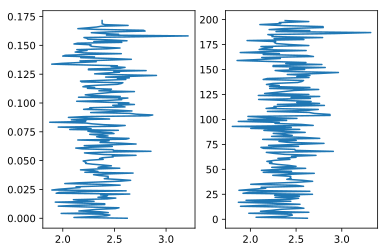

In [10]:
sample_number = 10
plt.subplot(1,2,1)
plt.plot(Vp_time[sample_number,:], time_upscaled)
plt.subplot(1,2,2)
plt.plot(Vp[sample_number,:], depth)


input1: Tensor("Const:0", shape=(2500, 246, 3), dtype=float32)


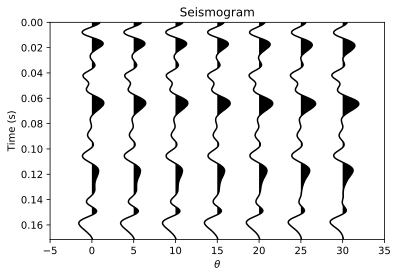

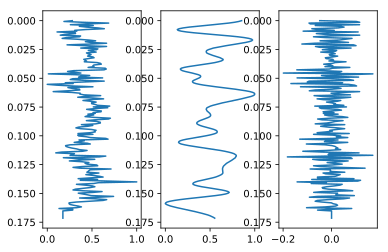

In [10]:
# Forward modeling results (Seismic gathers) (DONOT RUN IF NEW DATA IS NOT GENERATED)

# Test the forward modeling
bs=Vp_time.shape[0]
input11=np.zeros([bs,nt,3],dtype=np.float32)

input11[0:bs,:,0]=Vp_time[0:bs,:]
input11[0:bs,:,1]=Vs_time[0:bs,:]
input11[0:bs,:,2]=RHOB_time[0:bs,:]
# plt.plot(np.squeeze(input11))
# plt.show()

input111=tf.convert_to_tensor(input11,dtype=tf.float32)
# print("src:",src.shape)


tfsrc=tf.reshape(tf.constant(src,dtype=tf.float32),[src_len,1,1,1])


# print('tfsrc:',tfsrc)
# print('angle:',angle.shape)
tftheta=tf.convert_to_tensor(angle,dtype=tf.float32)
# print('tftheta:',tftheta)
seisgen=gather(input111,tftheta,tfsrc)


sess=tf.Session()
seis11,Rpp11=sess.run(seisgen)

sess.close()

seis=np.transpose(np.reshape(seis11,[-1,ntheta,nt]),[0,2,1])
Rpp=Rpp11#np.reshape(Rpp11,[bs,nt,ntheta])

sample_number = 20
wiggle(np.squeeze(seis[sample_number,:,:]),time_upscaled,theta)
plt.title("Seismogram")
plt.xlabel("$\\theta$")
plt.ylabel("Time (s)")
plt.show()

impedance_time = Vp_time * RHOB_time
impedance_time_sample = impedance_time[sample_number,:]
plt.subplot(1,3,1)
plt.plot((impedance_time_sample - np.min(impedance_time_sample))/(np.max(impedance_time_sample)-np.min(impedance_time_sample)), time_upscaled)
plt.gca().invert_yaxis()
plt.subplot(1,3,2)
seis_sample = np.squeeze(seis[sample_number,:,0])
plt.plot((seis_sample - np.min(seis_sample))/(np.max(seis_sample) - np.min(seis_sample)), time_upscaled)
plt.gca().invert_yaxis()
plt.subplot(1,3,3)
plt.plot(np.squeeze(Rpp[sample_number,:,0]), time_upscaled)
plt.gca().invert_yaxis()

In [16]:
# Exporting generated seismic data
np.save('../../../Data_generation_base_case/seismic_forward_modeled.npy', seis)
np.save('../../../Data_generation_base_case/Rpp_forward_modeled.npy', Rpp)


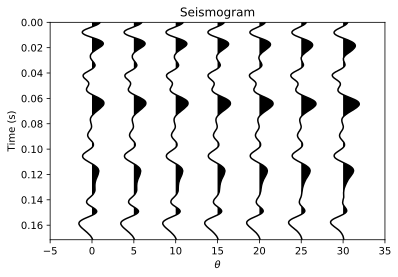

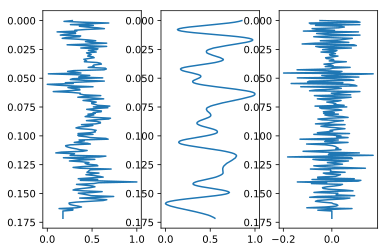

In [11]:
# Load forward modeled seismic data and Rpp
seis = np.load('../../../Data_generation_base_case/seismic_forward_modeled.npy')
Rpp = np.load('../../../Data_generation_base_case/Rpp_forward_modeled.npy')

sample_number = 20
wiggle(np.squeeze(seis[sample_number,:,:]),time_upscaled,theta)
plt.title("Seismogram")
plt.xlabel("$\\theta$")
plt.ylabel("Time (s)")
plt.show()

impedance_time = Vp_time * RHOB_time
impedance_time_sample = impedance_time[sample_number,:]
plt.subplot(1,3,1)
plt.plot((impedance_time_sample - np.min(impedance_time_sample))/(np.max(impedance_time_sample)-np.min(impedance_time_sample)), time_upscaled)
plt.gca().invert_yaxis()
plt.subplot(1,3,2)
seis_sample = np.squeeze(seis[sample_number,:,0])
plt.plot((seis_sample - np.min(seis_sample))/(np.max(seis_sample) - np.min(seis_sample)), time_upscaled)
plt.gca().invert_yaxis()
plt.subplot(1,3,3)
plt.plot(np.squeeze(Rpp[sample_number,:,0]), time_upscaled)
plt.gca().invert_yaxis()

In [12]:
# Import keras modules for CNN

from keras import layers, initializers, optimizers
from keras.layers import Input, Dense, Activation, ZeroPadding1D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling1D, MaxPooling2D, Dropout, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.layers import LeakyReLU, Reshape
from keras.models import Model, model_from_json
from keras.preprocessing import image
from keras.utils import layer_utils, normalize
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.utils import np_utils
# from kt_utils import *

import keras.backend as K
K.set_image_data_format('channels_last')

import sklearn.model_selection
import pydot

Using TensorFlow backend.


In [13]:
# Getting the input data (normalized) and output data 

# Reshape seismic gathers into (number of examples, angle, time) and normalize such that seismic traces have positive values
seis_reshaped = np.swapaxes(seis,1,2)
seis_reshaped_normalized = (seis_reshaped - np.min(seis_reshaped))/(np.max(seis_reshaped)-np.min(seis_reshaped))

# Concatenate Vp, Vs and Density 
num_examples = Vp_time.shape[0]
emodel = np.concatenate((Vp_time,Vs_time,RHOB_time), axis=1)
emodel = emodel.reshape((num_examples, 3, nt))


# Split data into train and test set - elastic model
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(seis_reshaped_normalized, 
                                                                            emodel, test_size=0.2, random_state=1)
# # Normalizing output
# Y_train = normalize(Y_train, axis=2, order=2)
# Y_test = normalize(Y_test, axis=2, order=2)


# Add 4th dimension of number of channels=1 to the input data
X_train = np.expand_dims(X_train, axis=3)
# # X_val = np.expand_dims(X_val, axis=3)
X_test = np.expand_dims(X_test, axis=3)


print ("number of training examples = " + str(X_train.shape[0]))
# print ("number of validation examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
# print ("X_val shape: " + str(X_val.shape))
# print ("Y_val shape: " + str(Y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))


number of training examples = 2000
number of test examples = 500
X_train shape: (2000, 7, 246, 1)
Y_train shape: (2000, 3, 246)
X_test shape: (500, 7, 246, 1)
Y_test shape: (500, 3, 246)


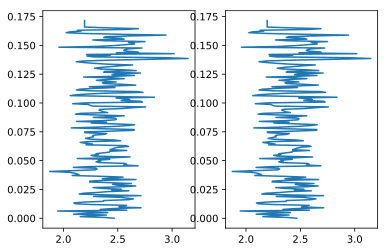

In [14]:
sample_number = 10

plt.subplot(1,2,1)
plt.plot(Y_train[sample_number, 0, :], time_upscaled)

plt.subplot(1,2,2)
plt.plot(Y_train[sample_number, 0, :], time_upscaled)

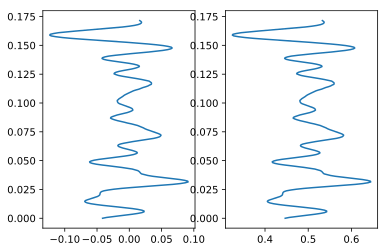

In [15]:
seis_reshaped_normalized = (seis_reshaped - np.min(seis_reshaped))/(np.max(seis_reshaped)-np.min(seis_reshaped))

plt.subplot(1,2,1)
plt.plot(np.squeeze(seis_reshaped[2,1,:]),time_upscaled)
plt.subplot(1,2,2)
plt.plot(np.squeeze(seis_reshaped_normalized[2,1,:]),time_upscaled)

In [16]:
# Building neural network for elastic properties prediction in Keras 
given_seed = 3 # For repeatibility

def elasticnet(input_shape):
    """
    Implementation of the AVONet.
    
    Arguments:
    input_shape -- shape of the images of the dataset

    Returns:
    model -- a Model() instance in Keras
    """
    

    # Define the input placeholder as a tensor with shape input_shape. Input = input angle gather 
    X_input = Input(input_shape)

    X = X_input

    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(10, (3, 35), strides=(1, 1), name='conv0',
               kernel_initializer=initializers.he_normal(seed=given_seed), bias_initializer='zeros')(X)
    X = BatchNormalization(axis=-1, name='bn0')(X)
    X = Activation('relu')(X)

    # MAXPOOL
#     X = MaxPooling2D((2, 2), strides=(1,1),name='max_pool0')(X)
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(1, (3, 35), strides=(1, 1), name='conv1',
               kernel_initializer=initializers.he_normal(seed=given_seed), bias_initializer='zeros')(X)
    X = BatchNormalization(axis=-1, name='bn1')(X)
    X = Activation('relu')(X)

    # MAXPOOL
    X = MaxPooling2D((2, 2), strides=(1,1),name='max_pool1')(X)
      

    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
    X = Flatten()(X)
#     X = Dense(1200, name='fc1')(X)
#     X = Activation('relu')(X)
    X = Dense(246*3, name='fc1')(X)
    X = Activation('relu')(X)
    
    X = Reshape((3, 246))(X)
    
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs=X_input, outputs=X, name='ElasticModel')

    return model
    ### END CODE HERE ###

In [17]:
# Create the model
ElasticModel = elasticnet(X_train.shape[1:])


In [18]:
# Summary and plot of the model

ElasticModel.summary()


# plot_model(AVOModel)
# SVG(model_to_dot(ElasticModel).create(prog='dot', format='svg'))
# plot_model(ElasticModel, to_file='./Figures/model_plot.png', show_shapes=True, show_layer_names=True)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 7, 246, 1)         0         
_________________________________________________________________
conv0 (Conv2D)               (None, 5, 212, 10)        1060      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 5, 212, 10)        40        
_________________________________________________________________
activation_1 (Activation)    (None, 5, 212, 10)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 3, 178, 1)         1051      
_________________________________________________________________
bn1 (BatchNormalization)     (None, 3, 178, 1)         4         
_________________________________________________________________
activation_2 (Activation)    (None, 3, 178, 1)         0         
__________

In [19]:
# Learning rate scheduler
from keras.callbacks import LearningRateScheduler
# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.01
    drop = 0.1
    epochs_drop = 250.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

In [20]:
# Compile the model with optimization algorithm, loss function
adam = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

ElasticModel.compile(loss='mean_squared_error', optimizer = adam)

In [83]:
# Start the training
# Using learning rate scheduler
lrate = LearningRateScheduler(step_decay)
callbacks_list = [lrate]
history = ElasticModel.fit(X_train, Y_train, validation_split=0.2, epochs=1000, batch_size=32, callbacks=callbacks_list)

# history = ElasticModel.fit(X_train, Y_train, validation_split=0.2, epochs=500, batch_size=32)

Train on 1600 samples, validate on 400 samples
Epoch 1/1000
1600/1600 [==============================] - 2s 1ms/step - loss: 0.2708 - val_loss: 0.3513
Epoch 2/1000
1600/1600 [==============================] - 0s 298us/step - loss: 0.0610 - val_loss: 0.7107
Epoch 3/1000
1600/1600 [==============================] - 0s 287us/step - loss: 0.0496 - val_loss: 1.0670
Epoch 4/1000
1600/1600 [==============================] - 0s 291us/step - loss: 0.0455 - val_loss: 0.8039
Epoch 5/1000
1600/1600 [==============================] - 0s 283us/step - loss: 0.0481 - val_loss: 0.3377
Epoch 6/1000
1600/1600 [==============================] - 0s 278us/step - loss: 0.0401 - val_loss: 0.0959
Epoch 7/1000
1600/1600 [==============================] - 0s 276us/step - loss: 0.0473 - val_loss: 0.3961
Epoch 8/1000
1600/1600 [==============================] - 0s 275us/step - loss: 0.0452 - val_loss: 1.0012
Epoch 9/1000
1600/1600 [==============================] - 0s 275us/step - loss: 0.0445 - val_loss: 0.0926
E

1600/1600 [==============================] - 0s 268us/step - loss: 0.0284 - val_loss: 0.0426
Epoch 154/1000
1600/1600 [==============================] - 0s 270us/step - loss: 0.0283 - val_loss: 0.0419
Epoch 155/1000
1600/1600 [==============================] - 0s 268us/step - loss: 0.0284 - val_loss: 0.0353
Epoch 156/1000
1600/1600 [==============================] - 0s 268us/step - loss: 0.0280 - val_loss: 0.0373
Epoch 157/1000
1600/1600 [==============================] - 0s 268us/step - loss: 0.0210 - val_loss: 0.0275
Epoch 158/1000
1600/1600 [==============================] - 0s 270us/step - loss: 0.0204 - val_loss: 0.0290
Epoch 159/1000
1600/1600 [==============================] - 0s 279us/step - loss: 0.0205 - val_loss: 0.0297
Epoch 160/1000
1600/1600 [==============================] - 0s 269us/step - loss: 0.0203 - val_loss: 0.0302
Epoch 161/1000
1600/1600 [==============================] - 0s 268us/step - loss: 0.0202 - val_loss: 0.0264
Epoch 162/1000
1600/1600 [=================

Epoch 229/1000
1600/1600 [==============================] - 0s 269us/step - loss: 0.0162 - val_loss: 0.0359
Epoch 230/1000
1600/1600 [==============================] - 0s 269us/step - loss: 0.0162 - val_loss: 0.0198
Epoch 231/1000
1600/1600 [==============================] - 0s 267us/step - loss: 0.0161 - val_loss: 0.0291
Epoch 232/1000
1600/1600 [==============================] - 0s 268us/step - loss: 0.0159 - val_loss: 0.0285
Epoch 233/1000
1600/1600 [==============================] - 0s 268us/step - loss: 0.0159 - val_loss: 0.0250
Epoch 234/1000
1600/1600 [==============================] - 0s 269us/step - loss: 0.0163 - val_loss: 0.0221
Epoch 235/1000
1600/1600 [==============================] - 0s 267us/step - loss: 0.0159 - val_loss: 0.0195
Epoch 236/1000
1600/1600 [==============================] - 0s 268us/step - loss: 0.0156 - val_loss: 0.0227
Epoch 237/1000
1600/1600 [==============================] - 0s 268us/step - loss: 0.0157 - val_loss: 0.0265
Epoch 238/1000
1600/1600 [==

Epoch 305/1000
1600/1600 [==============================] - 0s 267us/step - loss: 0.0136 - val_loss: 0.0173
Epoch 306/1000
1600/1600 [==============================] - 0s 269us/step - loss: 0.0136 - val_loss: 0.0173
Epoch 307/1000
1600/1600 [==============================] - 0s 269us/step - loss: 0.0136 - val_loss: 0.0172
Epoch 308/1000
1600/1600 [==============================] - 0s 269us/step - loss: 0.0136 - val_loss: 0.0174
Epoch 309/1000
1600/1600 [==============================] - 0s 267us/step - loss: 0.0136 - val_loss: 0.0178
Epoch 310/1000
1600/1600 [==============================] - 0s 266us/step - loss: 0.0136 - val_loss: 0.0173
Epoch 311/1000
1600/1600 [==============================] - 0s 270us/step - loss: 0.0136 - val_loss: 0.0170
Epoch 312/1000
1600/1600 [==============================] - 0s 269us/step - loss: 0.0135 - val_loss: 0.0170
Epoch 313/1000
1600/1600 [==============================] - 0s 275us/step - loss: 0.0135 - val_loss: 0.0181
Epoch 314/1000
1600/1600 [==

Epoch 381/1000
1600/1600 [==============================] - 0s 272us/step - loss: 0.0132 - val_loss: 0.0168
Epoch 382/1000
1600/1600 [==============================] - 0s 271us/step - loss: 0.0132 - val_loss: 0.0168
Epoch 383/1000
1600/1600 [==============================] - 0s 270us/step - loss: 0.0134 - val_loss: 0.0168
Epoch 384/1000
1600/1600 [==============================] - 0s 273us/step - loss: 0.0132 - val_loss: 0.0168
Epoch 385/1000
1600/1600 [==============================] - 0s 274us/step - loss: 0.0132 - val_loss: 0.0171
Epoch 386/1000
1600/1600 [==============================] - 0s 272us/step - loss: 0.0132 - val_loss: 0.0168
Epoch 387/1000
1600/1600 [==============================] - 0s 272us/step - loss: 0.0132 - val_loss: 0.0169
Epoch 388/1000
1600/1600 [==============================] - 0s 271us/step - loss: 0.0132 - val_loss: 0.0168
Epoch 389/1000
1600/1600 [==============================] - 0s 273us/step - loss: 0.0132 - val_loss: 0.0168
Epoch 390/1000
1600/1600 [==

Epoch 457/1000
1600/1600 [==============================] - 0s 269us/step - loss: 0.0130 - val_loss: 0.0173
Epoch 458/1000
1600/1600 [==============================] - 0s 270us/step - loss: 0.0129 - val_loss: 0.0169
Epoch 459/1000
1600/1600 [==============================] - 0s 271us/step - loss: 0.0129 - val_loss: 0.0170
Epoch 460/1000
1600/1600 [==============================] - 0s 272us/step - loss: 0.0129 - val_loss: 0.0165
Epoch 461/1000
1600/1600 [==============================] - 0s 269us/step - loss: 0.0130 - val_loss: 0.0166
Epoch 462/1000
1600/1600 [==============================] - 0s 269us/step - loss: 0.0129 - val_loss: 0.0168
Epoch 463/1000
1600/1600 [==============================] - 0s 267us/step - loss: 0.0129 - val_loss: 0.0166
Epoch 464/1000
1600/1600 [==============================] - 0s 268us/step - loss: 0.0129 - val_loss: 0.0167
Epoch 465/1000
1600/1600 [==============================] - 0s 269us/step - loss: 0.0129 - val_loss: 0.0167
Epoch 466/1000
1600/1600 [==

Epoch 533/1000
1600/1600 [==============================] - 0s 269us/step - loss: 0.0126 - val_loss: 0.0164
Epoch 534/1000
1600/1600 [==============================] - 0s 276us/step - loss: 0.0126 - val_loss: 0.0164
Epoch 535/1000
1600/1600 [==============================] - 0s 272us/step - loss: 0.0126 - val_loss: 0.0164
Epoch 536/1000
1600/1600 [==============================] - 0s 270us/step - loss: 0.0126 - val_loss: 0.0164
Epoch 537/1000
1600/1600 [==============================] - 0s 269us/step - loss: 0.0126 - val_loss: 0.0164
Epoch 538/1000
1600/1600 [==============================] - 0s 271us/step - loss: 0.0126 - val_loss: 0.0164
Epoch 539/1000
1600/1600 [==============================] - 0s 273us/step - loss: 0.0126 - val_loss: 0.0164
Epoch 540/1000
1600/1600 [==============================] - 0s 277us/step - loss: 0.0126 - val_loss: 0.0164
Epoch 541/1000
1600/1600 [==============================] - 0s 270us/step - loss: 0.0126 - val_loss: 0.0164
Epoch 542/1000
1600/1600 [==

Epoch 609/1000
1600/1600 [==============================] - 0s 269us/step - loss: 0.0126 - val_loss: 0.0163
Epoch 610/1000
1600/1600 [==============================] - 0s 270us/step - loss: 0.0126 - val_loss: 0.0164
Epoch 611/1000
1600/1600 [==============================] - 0s 269us/step - loss: 0.0126 - val_loss: 0.0163
Epoch 612/1000
1600/1600 [==============================] - 0s 267us/step - loss: 0.0126 - val_loss: 0.0163
Epoch 613/1000
1600/1600 [==============================] - 0s 269us/step - loss: 0.0126 - val_loss: 0.0164
Epoch 614/1000
1600/1600 [==============================] - 0s 271us/step - loss: 0.0126 - val_loss: 0.0163
Epoch 615/1000
1600/1600 [==============================] - 0s 271us/step - loss: 0.0126 - val_loss: 0.0163
Epoch 616/1000
1600/1600 [==============================] - 0s 268us/step - loss: 0.0126 - val_loss: 0.0163
Epoch 617/1000
1600/1600 [==============================] - 0s 267us/step - loss: 0.0126 - val_loss: 0.0164
Epoch 618/1000
1600/1600 [==

Epoch 685/1000
1600/1600 [==============================] - 0s 270us/step - loss: 0.0126 - val_loss: 0.0163
Epoch 686/1000
1600/1600 [==============================] - 0s 269us/step - loss: 0.0126 - val_loss: 0.0163
Epoch 687/1000
1600/1600 [==============================] - 0s 271us/step - loss: 0.0126 - val_loss: 0.0163
Epoch 688/1000
1600/1600 [==============================] - 0s 269us/step - loss: 0.0126 - val_loss: 0.0163
Epoch 689/1000
1600/1600 [==============================] - 0s 268us/step - loss: 0.0126 - val_loss: 0.0163
Epoch 690/1000
1600/1600 [==============================] - 0s 269us/step - loss: 0.0125 - val_loss: 0.0163
Epoch 691/1000
1600/1600 [==============================] - 0s 268us/step - loss: 0.0126 - val_loss: 0.0163
Epoch 692/1000
1600/1600 [==============================] - 0s 270us/step - loss: 0.0126 - val_loss: 0.0163
Epoch 693/1000
1600/1600 [==============================] - 0s 270us/step - loss: 0.0126 - val_loss: 0.0164
Epoch 694/1000
1600/1600 [==

Epoch 761/1000
1600/1600 [==============================] - 0s 273us/step - loss: 0.0125 - val_loss: 0.0163
Epoch 762/1000
1600/1600 [==============================] - 0s 272us/step - loss: 0.0125 - val_loss: 0.0163
Epoch 763/1000
1600/1600 [==============================] - 0s 270us/step - loss: 0.0125 - val_loss: 0.0163
Epoch 764/1000
1600/1600 [==============================] - 0s 272us/step - loss: 0.0125 - val_loss: 0.0163
Epoch 765/1000
1600/1600 [==============================] - 0s 270us/step - loss: 0.0125 - val_loss: 0.0163
Epoch 766/1000
1600/1600 [==============================] - 0s 271us/step - loss: 0.0125 - val_loss: 0.0163
Epoch 767/1000
1600/1600 [==============================] - 0s 269us/step - loss: 0.0125 - val_loss: 0.0163
Epoch 768/1000
1600/1600 [==============================] - 0s 270us/step - loss: 0.0125 - val_loss: 0.0163
Epoch 769/1000
1600/1600 [==============================] - 0s 269us/step - loss: 0.0125 - val_loss: 0.0163
Epoch 770/1000
1600/1600 [==

Epoch 837/1000
1600/1600 [==============================] - 0s 267us/step - loss: 0.0125 - val_loss: 0.0163
Epoch 838/1000
1600/1600 [==============================] - 0s 269us/step - loss: 0.0125 - val_loss: 0.0163
Epoch 839/1000
1600/1600 [==============================] - 0s 270us/step - loss: 0.0125 - val_loss: 0.0163
Epoch 840/1000
1600/1600 [==============================] - 0s 269us/step - loss: 0.0125 - val_loss: 0.0163
Epoch 841/1000
1600/1600 [==============================] - 0s 271us/step - loss: 0.0125 - val_loss: 0.0163
Epoch 842/1000
1600/1600 [==============================] - 0s 267us/step - loss: 0.0125 - val_loss: 0.0163
Epoch 843/1000
1600/1600 [==============================] - 0s 266us/step - loss: 0.0125 - val_loss: 0.0163
Epoch 844/1000
1600/1600 [==============================] - 0s 268us/step - loss: 0.0125 - val_loss: 0.0163
Epoch 845/1000
1600/1600 [==============================] - 0s 270us/step - loss: 0.0125 - val_loss: 0.0163
Epoch 846/1000
1600/1600 [==

Epoch 913/1000
1600/1600 [==============================] - 0s 268us/step - loss: 0.0125 - val_loss: 0.0163
Epoch 914/1000
1600/1600 [==============================] - 0s 273us/step - loss: 0.0125 - val_loss: 0.0163
Epoch 915/1000
1600/1600 [==============================] - 0s 270us/step - loss: 0.0125 - val_loss: 0.0163
Epoch 916/1000
1600/1600 [==============================] - 0s 268us/step - loss: 0.0125 - val_loss: 0.0163
Epoch 917/1000
1600/1600 [==============================] - 0s 269us/step - loss: 0.0125 - val_loss: 0.0163
Epoch 918/1000
1600/1600 [==============================] - 0s 267us/step - loss: 0.0125 - val_loss: 0.0163
Epoch 919/1000
1600/1600 [==============================] - 0s 269us/step - loss: 0.0125 - val_loss: 0.0163
Epoch 920/1000
1600/1600 [==============================] - 0s 269us/step - loss: 0.0125 - val_loss: 0.0163
Epoch 921/1000
1600/1600 [==============================] - 0s 268us/step - loss: 0.0125 - val_loss: 0.0163
Epoch 922/1000
1600/1600 [==

Epoch 989/1000
1600/1600 [==============================] - 0s 271us/step - loss: 0.0125 - val_loss: 0.0163
Epoch 990/1000
1600/1600 [==============================] - 0s 270us/step - loss: 0.0125 - val_loss: 0.0163
Epoch 991/1000
1600/1600 [==============================] - 0s 268us/step - loss: 0.0125 - val_loss: 0.0163
Epoch 992/1000
1600/1600 [==============================] - 0s 269us/step - loss: 0.0125 - val_loss: 0.0163
Epoch 993/1000
1600/1600 [==============================] - 0s 269us/step - loss: 0.0125 - val_loss: 0.0163
Epoch 994/1000
1600/1600 [==============================] - 0s 267us/step - loss: 0.0125 - val_loss: 0.0163
Epoch 995/1000
1600/1600 [==============================] - 0s 269us/step - loss: 0.0125 - val_loss: 0.0163
Epoch 996/1000
1600/1600 [==============================] - 0s 266us/step - loss: 0.0125 - val_loss: 0.0163
Epoch 997/1000
1600/1600 [==============================] - 0s 268us/step - loss: 0.0125 - val_loss: 0.0163
Epoch 998/1000
1600/1600 [==

In [22]:
# Testing and evaluating the model
preds = ElasticModel.evaluate(X_test, Y_test, batch_size=32, verbose=1, sample_weight=None)
print()
print ("Loss = " + str(preds))
# print ("Test Accuracy = " + str(preds[1]))

500/500 [==============================] - 1s 1ms/step

Loss = 2.872924259185791


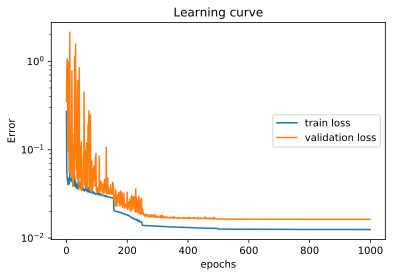

In [85]:
# Plotting the learning curve 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yscale("log")
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])


plt.title('Learning curve')
# plt.ylabel('Error/Accuracy')
plt.ylabel('Error')
plt.xlabel('epochs')
plt.legend(['train loss', 'validation loss'], loc='center right')
# plt.savefig('/Figures/learning_curve_08Nov.png', bbox_inches='tight')

In [89]:
# Save trained model 
# serialize model to JSON
model_json = ElasticModel.to_json()
with open("elastic_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
ElasticModel.save_weights("ElasticModel.h5")
print("Saved model to disk")

Saved model to disk


In [21]:
# Load saved model
# load json and create model
json_file = open('elastic_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("ElasticModel.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
adam = optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)


ElasticModel.compile(loss='mean_squared_error', optimizer = adam)


# To evaluate run the "Testing and evaluating the model" cell

Loaded model from disk


In [23]:
# Predict training and test data using the trained network
test_output = ElasticModel.predict(X_test)
train_output = ElasticModel.predict(X_train)

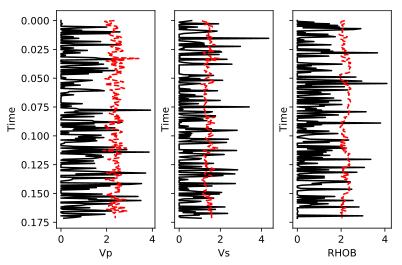

In [24]:
# Checking training data

sample_number = 15
f, axarr = plt.subplots(1, 3, sharey = True)

axarr[0].plot(train_output[sample_number, 0, :], time_upscaled, '-k')
axarr[0].plot(Y_train[sample_number, 0, :], time_upscaled, '--r')
axarr[0].set_xlabel("Vp")
axarr[0].set_ylabel("Time")
axarr[0].invert_yaxis()
# axarr[0].set_xlim(1.5,3.1)

axarr[1].plot(train_output[sample_number, 1, :], time_upscaled, '-k')
axarr[1].plot(Y_train[sample_number, 1, :], time_upscaled, '--r')
axarr[1].set_xlabel("Vs")
axarr[1].set_ylabel("Time")
axarr[1].invert_yaxis()
# axarr[1].set_xlim(1,2)

axarr[2].plot(train_output[sample_number, 2, :], time_upscaled, '-k')
axarr[2].plot(Y_train[sample_number, 2, :], time_upscaled, '--r')
axarr[2].set_xlabel("RHOB")
axarr[2].set_ylabel("Time")
axarr[2].invert_yaxis()
# axarr[2].set_xlim(1.5,3)

(1.5, 3)

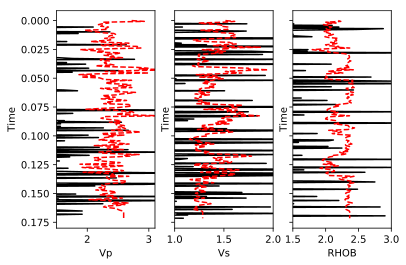

In [25]:
# Checking testing data

sample_number = 12
f, axarr = plt.subplots(1, 3, sharey = True)

axarr[0].plot(test_output[sample_number, 0, :], time_upscaled, '-k')
axarr[0].plot(Y_test[sample_number, 0, :], time_upscaled, '--r')
axarr[0].set_xlabel("Vp")
axarr[0].set_ylabel("Time")
axarr[0].invert_yaxis()
axarr[0].set_xlim(1.5,3.1)

axarr[1].plot(test_output[sample_number, 1, :], time_upscaled, '-k')
axarr[1].plot(Y_test[sample_number, 1, :], time_upscaled, '--r')
axarr[1].set_xlabel("Vs")
axarr[1].set_ylabel("Time")
axarr[1].invert_yaxis()
axarr[1].set_xlim(1,2)

axarr[2].plot(test_output[sample_number, 2, :], time_upscaled, '-k')
axarr[2].plot(Y_test[sample_number, 2, :], time_upscaled, '--r')
axarr[2].set_xlabel("RHOB")
axarr[2].set_ylabel("Time")
axarr[2].invert_yaxis()
axarr[2].set_xlim(1.5,3)

In [49]:
# Correlation coefficient between true and predicted traces 

Vp_corr_train = np.zeros(train_output.shape[0])
Vs_corr_train = np.zeros(train_output.shape[0])
RHOB_corr_train = np.zeros(train_output.shape[0])
for i in range(train_output.shape[0]):
    Vp_corr_train[i] = np.corrcoef(train_output[i,0,:], Y_train[i,0,:])[0,1]
    Vs_corr_train[i] = np.corrcoef(train_output[i,1,:], Y_train[i,1,:])[0,1]
    RHOB_corr_train[i] = np.corrcoef(train_output[i,2,:], Y_train[i,2,:])[0,1]
    
Vp_corr_test = np.zeros(test_output.shape[0])
Vs_corr_test = np.zeros(test_output.shape[0])
RHOB_corr_test = np.zeros(test_output.shape[0])
for i in range(test_output.shape[0]):
    Vp_corr_test[i] = np.corrcoef(test_output[i,0,:], Y_test[i,0,:])[0,1]
    Vs_corr_test[i] = np.corrcoef(test_output[i,1,:], Y_test[i,1,:])[0,1]
    RHOB_corr_test[i] = np.corrcoef(test_output[i,2,:], Y_test[i,2,:])[0,1]

    
# Average correlation coefficient
print("Average correlation in Vp for training data = ", np.mean(Vp_corr_train))
print("Average correlation in Vs for training data = ", np.mean(Vs_corr_train))
print("Average correlation in RHOB for training data = ", np.mean(RHOB_corr_train))

print("Average correlation in Vp for training data = ", np.mean(Vp_corr_test))
print("Average correlation in Vs for training data = ", np.mean(Vs_corr_test))
print("Average correlation in RHOB for training data = ", np.mean(RHOB_corr_test))

Average correlation in Vp for training data =  -0.00019139561002362305
Average correlation in Vs for training data =  -8.730966453854911e-05
Average correlation in RHOB for training data =  -0.001736309089477864
Average correlation in Vp for training data =  0.003076640288639503
Average correlation in Vs for training data =  0.004958788425350046
Average correlation in RHOB for training data =  0.0011921444308216067


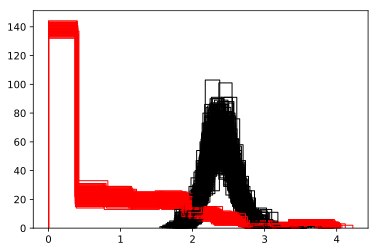

In [59]:
# Histogram plot for true vs predicted values
for i in range(train_output.shape[0]):
    plt.hist(Y_train[i,0,:], histtype='step', color='black', alpha=0.5)
    plt.hist(train_output[i,0,:], histtype='step', color='red', alpha=0.5)
    plt.xlabel('Vp (km/sec)')
    plt.ylabel('Frequency')
    plt.title('Training examples')




In [ ]:
# Histogram plot for true vs predicted values
for i in range(train_output.shape[0]):
    plt.hist(Y_train[i,1,:], histtype='step', color='black')
    plt.hist(train_output[i,0,:], histtype='step', color='red')
    plt.xlabel('Vs (km/sec)')
    plt.ylabel('Frequency')
    plt.title('Training examples')

In [ ]:
# Histogram plot for true vs predicted values
for i in range(train_output.shape[0]):
    plt.hist(Y_train[i,2,:], histtype='step', color='black')
    plt.hist(train_output[i,0,:], histtype='step', color='red')
    plt.xlabel('RHOB (gm/cc)')
    plt.ylabel('Frequency')
    plt.title('Training examples')

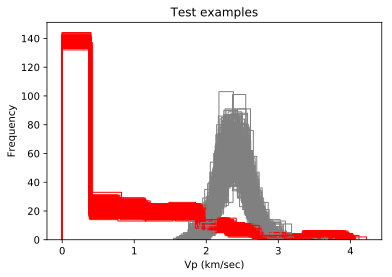

In [63]:
for i in range(test_output.shape[0]):
    plt.hist(Y_test[i,0,:], histtype='step', color='black')
    plt.hist(test_output[i,0,:], histtype='step', color='red')
    plt.xlabel('Vp (km/sec)')
    plt.ylabel('Frequency')
    plt.title('Test examples')
    

In [ ]:
for i in range(test_output.shape[0]):
    plt.hist(Y_test[i,1,:], histtype='step', color='black')
    plt.hist(test_output[i,1,:], histtype='step', color='red')
    plt.xlabel('Vs (km/sec)')
    plt.ylabel('Frequency')
    plt.title('Test examples')

In [ ]:
for i in range(test_output.shape[0]):
    plt.hist(Y_test[i,2,:], histtype='step', color='black')
    plt.hist(test_output[i,2,:], histtype='step', color='red')
    plt.xlabel('RHOB (gm/cc)')
    plt.ylabel('Frequency')
    plt.title('Test examples')